In [1]:
import numpy as np
import scipy.stats as sps
import os
import csv
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
currentdir = os.getcwd()
datadir = os.path.join(currentdir,'OxytocinRSData_new')
print(datadir)

/Users/hstrey/Documents/programming/fMRI-analysis/OxytocinRSData_new


In [3]:
# get data files names
datafilenames = os.listdir(datadir)
print(datafilenames)

['Subject002.npy', 'Subject003.npy', 'Subject001.npy', 'Subject004.npy', 'Subject005.npy']


In [4]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)

In [5]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


mean MPFC:  -5.0998628e-09
var:  1.000000476837215
N:  748
relaxation time: 6.303452036864351 SD tau 0.9664160564041558
A  0.9921413761036094 SD A 0.1429234278901148
mean PCC:  7.649794e-09
var:  1.0
relaxation time: 7.217649153672873 SD tau 1.1838541637882665
A  1.0062769259605675 SD A 0.15611971630909358
mean RLP:  -5.7373453e-09
var:  1.0000002384185933
relaxation time: 7.295618221484745 SD tau 1.2097079756582125
A  1.0163723874782427 SD A 0.15939209587816294
mean LLP:  -7.649794e-09
var:  0.9999996423721633
relaxation time: 5.16055971048208 SD tau 0.7357751230745184
A  1.0098735194946864 SD A 0.13325862844354566
mean MPFC:  7.012311e-09
var:  1.0
N:  748
relaxation time: 4.951798624556315 SD tau 0.7158666195196934
A  1.0555732603661954 SD A 0.14011353256241396
mean PCC:  1.2749657e-09
var:  1.0
relaxation time: 7.989069847219934 SD tau 1.3656366756565408
A  1.0009735825910855 SD A 0.16274570699835292
mean RLP:  -1.5299587e-08
var:  1.0000002384185933
relaxation time: 5.685660149842

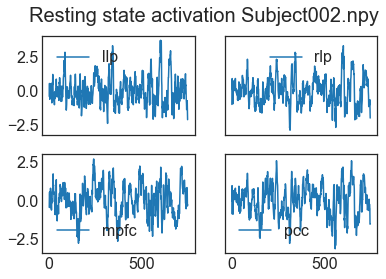

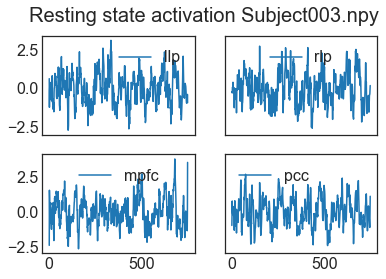

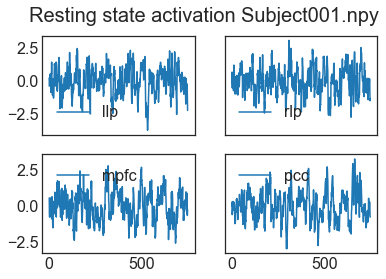

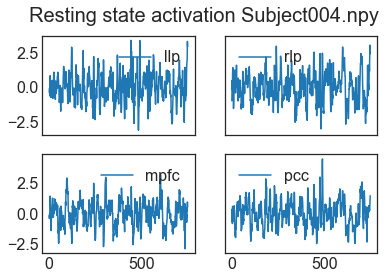

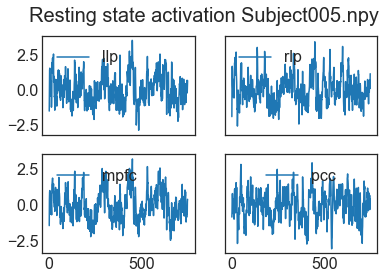

In [6]:
results = None
for datafilename in datafilenames:
    time_series = np.load(os.path.join(datadir,datafilename))
    mpfc = time_series[:,0]
    llp = time_series[:,1]
    rlp = time_series[:,2]
    pcc = time_series[:,3]
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    f.suptitle('Resting state activation '+datafilename)
    ax1.plot(llp, label="llp")
    ax1.legend()
    ax2.plot(rlp,label = "rlp")
    ax2.legend()
    ax3.plot(mpfc,label = "mpfc")
    ax3.legend()
    ax4.plot(pcc,label = "pcc")
    ax4.legend()
    
    print("mean MPFC: ",mpfc.mean())
    print("var: ",mpfc.std()**2)
    N=len(mpfc)
    print("N: ",N)
    mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
    print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
    print("A ",mpfc_A,"SD A",mpfc_sA)
    mpfc_norm=mpfc/np.sqrt(mpfc_A)
    t = np.arange(N)*0.802 # tR = 0.802 sec

    print("mean PCC: ",pcc.mean())
    print("var: ",pcc.std()**2)
    pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
    print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
    print("A ",pcc_A,"SD A",pcc_sA)
    pcc_norm=pcc/np.sqrt(pcc_A)
    
    print("mean RLP: ",rlp.mean())
    print("var: ",rlp.std()**2)
    rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
    print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
    print("A ",rlp_A,"SD A",rlp_sA)
    rlp_norm=rlp/np.sqrt(rlp_A)
    
    print("mean LLP: ",llp.mean())
    print("var: ",llp.std()**2)
    llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
    print("relaxation time:",llp_tau, "SD tau", llp_dtau)
    print("A ",llp_A,"SD A",llp_sA)
    llp_norm=llp/np.sqrt(llp_A)
    
    mpfc_pcc,mpfc_pcc_sd = OUcross(mpfc_norm,pcc_norm)
    mpfc_rlp,mpfc_rlp_sd = OUcross(mpfc_norm,rlp_norm)
    mpfc_llp,mpfc_llp_sd = OUcross(mpfc_norm,llp_norm)
    pcc_rlp,pcc_rlp_sd = OUcross(pcc_norm,rlp_norm)
    pcc_llp,pcc_llp_sd = OUcross(pcc_norm,llp_norm)
    rlp_llp,rlp_llp_sd = OUcross(rlp_norm,llp_norm)
    
    mpfc_pcc_pc,mpfc_pcc_pv = sps.pearsonr(mpfc_norm,pcc_norm)
    mpfc_rlp_pc,mpfc_rlp_pv = sps.pearsonr(mpfc_norm,rlp_norm)
    mpfc_llp_pc,mpfc_llp_pv = sps.pearsonr(mpfc_norm,llp_norm)
    pcc_rlp_pc,pcc_rlp_pv = sps.pearsonr(pcc_norm,rlp_norm)
    pcc_llp_pc,pcc_llp_pv = sps.pearsonr(pcc_norm,llp_norm)
    rlp_llp_pc,rlp_llp_pv = sps.pearsonr(rlp_norm,llp_norm)
    
    result = np.array([mpfc_pcc,
                       mpfc_pcc_sd,
                        mpfc_rlp,
                       mpfc_rlp_sd,
                        mpfc_llp,
                       mpfc_llp_sd,
                        pcc_rlp,
                       pcc_rlp_sd,
                        pcc_llp,
                       pcc_llp_sd,
                        rlp_llp,
                       rlp_llp_sd,
                        mpfc_pcc_pc,
                       mpfc_pcc_pv,
                        mpfc_rlp_pc,
                       mpfc_rlp_pv,
                        mpfc_llp_pc,
                       mpfc_llp_pv,
                        pcc_rlp_pc,
                       pcc_rlp_pv,
                        pcc_llp_pc,
                       pcc_llp_pv,
                        rlp_llp_pc,
                       rlp_llp_pv])
    
    if results is None:
        results = result
    else:
        results = np.vstack((results,result))
        

In [7]:
x = ['1','2','3','4','5','mean']
np.append(results.T[0],[results.T[0].mean()])

array([3.03169143, 2.65864527, 1.2435271 , 0.94052167, 1.8311872 ,
       1.94111453])

In [8]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=mpfc_norm)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:46<00:00, 2553.53draws/s]


In [9]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
B,0.817,0.022,0.776,0.857,0.000,0.000,20268.0,20180.0,20216.0,19335.0,1.0
A,1.031,0.127,0.812,1.271,0.001,0.001,19032.0,18323.0,20190.0,18723.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89b1bee5c0>,
      dtype=object)

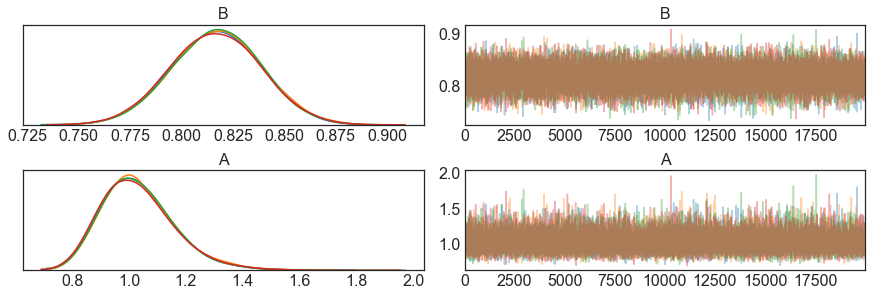

In [10]:
pm.traceplot(trace)

In [11]:
# relaxation time
print(-0.802/np.log(0.817))

3.9680147509383494


In [12]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(mpfc_norm))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=mpfc_norm)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 772 divergences: 100%|██████████| 42000/42000 [01:21<00:00, 516.23draws/s]
There were 772 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5427327428245128, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-1.156,0.232,-1.561,-0.705,0.009,0.006,681.0,674.0,681.0,5721.0,1.01
path[1],0.272,0.195,-0.106,0.629,0.004,0.003,2527.0,2527.0,2693.0,9117.0,1.00
path[2],0.834,0.193,0.446,1.185,0.003,0.002,5837.0,5837.0,6385.0,9310.0,1.00
path[3],0.929,0.192,0.555,1.281,0.003,0.002,4893.0,4893.0,5384.0,9623.0,1.00
path[4],0.441,0.189,0.078,0.802,0.001,0.002,17097.0,6777.0,18508.0,12665.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
path[746],0.188,0.190,-0.173,0.552,0.002,0.001,12865.0,12865.0,13901.0,12284.0,1.00
path[747],0.375,0.200,-0.018,0.746,0.001,0.001,30827.0,30827.0,33524.0,15180.0,1.00
B,0.855,0.026,0.807,0.903,0.001,0.001,375.0,375.0,386.0,936.0,1.01
A,0.988,0.143,0.736,1.253,0.001,0.001,19108.0,19108.0,17539.0,18649.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f898b240cf8>,
      dtype=object)

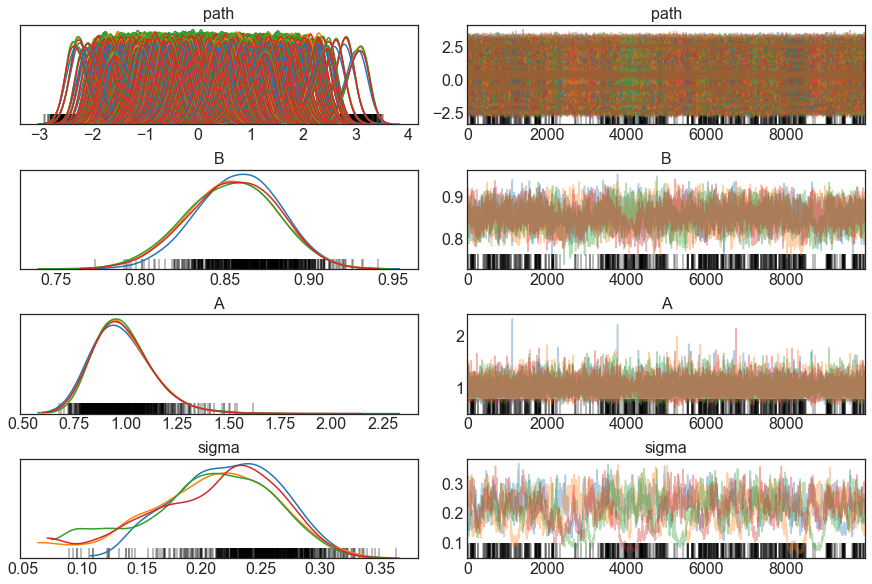

In [14]:
pm.traceplot(trace)

In [15]:
# relaxation time
print(-0.802/np.log(0.855))

5.119569066131811


In [42]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=5)
    ampl_noise = pm.Uniform('ampl_noise',0,5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(mpfc_norm))
    fmri_observed = pm.Normal('fmri_observed',
                              mu=path,
                              sigma=np.sqrt(sigma**2+ampl_noise**2*path**2), observed=mpfc_norm)
    trace = pm.sample(10000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, ampl_noise, sigma, A, B]
Sampling 4 chains, 2,943 divergences: 100%|██████████| 42000/42000 [01:49<00:00, 382.85draws/s]
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 385 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6897025147826542, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2365 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6159094610568706, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampl

In [43]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-1.150,0.224,-1.544,-0.716,0.014,0.011,243.0,223.0,225.0,3471.0,1.02
path[1],0.283,0.192,-0.110,0.620,0.007,0.005,864.0,864.0,904.0,5806.0,1.01
path[2],0.843,0.194,0.463,1.193,0.010,0.007,418.0,418.0,422.0,9021.0,1.01
path[3],0.931,0.191,0.550,1.276,0.004,0.003,1909.0,1909.0,2000.0,8235.0,1.01
path[4],0.441,0.187,0.086,0.795,0.002,0.002,6145.0,4320.0,6038.0,11547.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
path[747],0.381,0.196,-0.003,0.753,0.002,0.002,6881.0,6795.0,6648.0,7397.0,1.01
B,0.857,0.024,0.811,0.903,0.001,0.001,288.0,288.0,291.0,775.0,1.02
A,0.990,0.145,0.742,1.258,0.004,0.003,1236.0,1236.0,990.0,2781.0,1.01
sigma,0.202,0.057,0.065,0.294,0.011,0.008,25.0,25.0,49.0,16.0,1.09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86a441a748>,
      dtype=object)

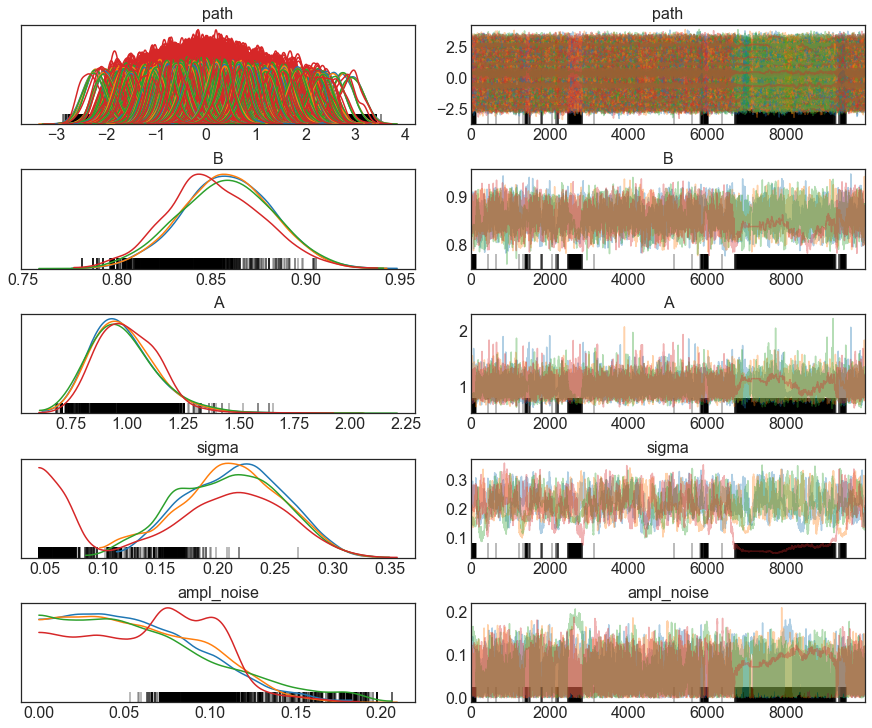

In [44]:
pm.traceplot(trace)

In [16]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=pcc_norm)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:46<00:00, 2598.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [17]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
B,0.803,0.022,0.761,0.845,0.000,0.000,18983.0,18916.0,18983.0,19785.0,1.0
A,1.029,0.122,0.814,1.255,0.001,0.001,18336.0,17733.0,19257.0,19533.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88f6f9de80>,
      dtype=object)

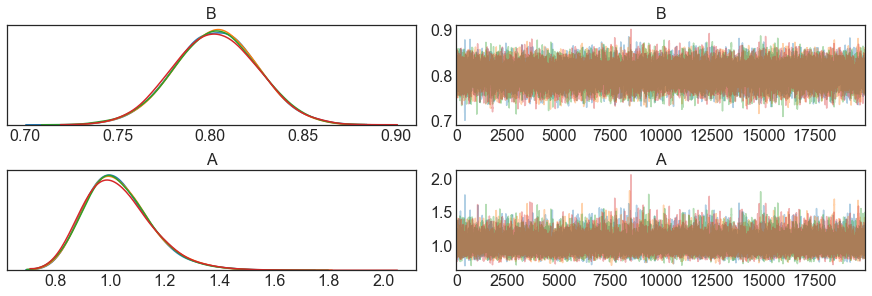

In [18]:
pm.traceplot(trace)

In [19]:
# relaxation time
print(-0.802/np.log(0.803))

3.655414469286752


In [20]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(pcc_norm))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=pcc_norm)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 769 divergences: 100%|██████████| 42000/42000 [01:35<00:00, 439.66draws/s]
There were 769 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2599834914285688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.18597085888723355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7064580302805367, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-0.812,0.063,-0.938,-0.692,0.001,0.000,15239.0,15239.0,14073.0,477.0,1.04
path[1],-0.412,0.064,-0.535,-0.283,0.001,0.001,5872.0,5872.0,5079.0,409.0,1.03
path[2],0.725,0.064,0.597,0.849,0.001,0.001,1997.0,1997.0,5993.0,384.0,1.05
path[3],0.814,0.063,0.693,0.939,0.000,0.000,36453.0,36178.0,21693.0,353.0,1.06
path[4],0.751,0.064,0.622,0.872,0.000,0.000,18120.0,18120.0,13761.0,351.0,1.05
...,...,...,...,...,...,...,...,...,...,...,...
path[746],-0.087,0.063,-0.210,0.041,0.000,0.002,28017.0,654.0,20437.0,435.0,1.05
path[747],0.414,0.065,0.289,0.544,0.000,0.000,20715.0,20715.0,20488.0,575.0,1.05
B,0.806,0.023,0.766,0.851,0.001,0.001,270.0,264.0,276.0,552.0,1.01
A,1.029,0.127,0.802,1.272,0.010,0.007,171.0,159.0,220.0,483.0,1.02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8861ecf7f0>,
      dtype=object)

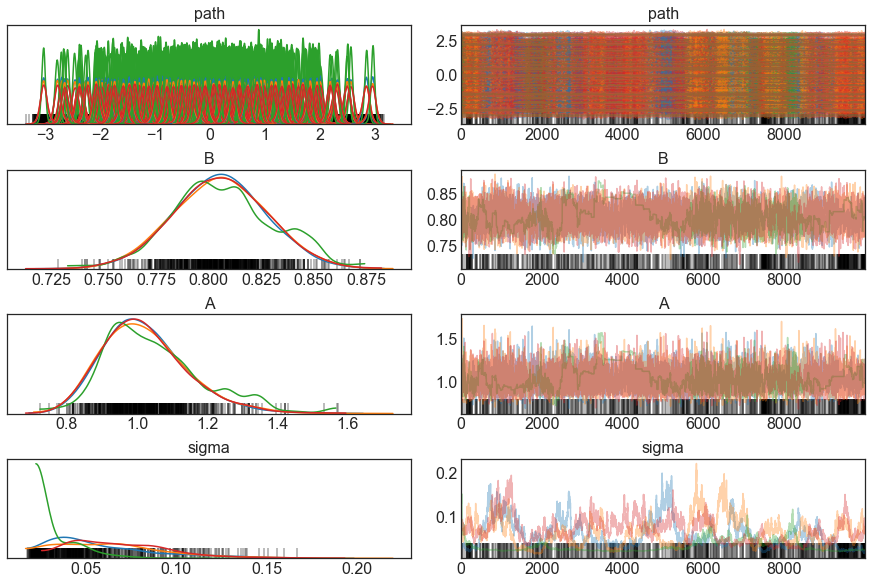

In [24]:
pm.traceplot(trace)

In [25]:
print(-0.802/np.log(0.806))

3.7186177328090477


In [26]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=rlp_norm)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:43<00:00, 2755.33draws/s]
The acceptance probability does not match the target. It is 0.6842031503153398, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
B,0.798,0.023,0.755,0.841,0.000,0.000,15936.0,15852.0,15907.0,17740.0,1.0
A,1.030,0.122,0.811,1.254,0.001,0.001,15173.0,14826.0,15816.0,17756.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87d5398630>,
      dtype=object)

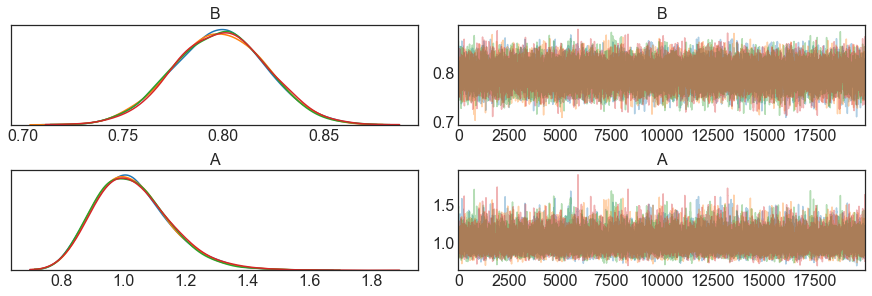

In [28]:
pm.traceplot(trace)

In [29]:
print(-0.802/np.log(0.798))

3.5542290919314854


In [30]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(rlp_norm))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=rlp_norm)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [01:02<00:00, 668.83draws/s] 
The acceptance probability does not match the target. It is 0.6942143819265457, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5917484538633849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5699135971349197, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [31]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-1.818,0.158,-2.068,-1.496,0.013,0.010,140.0,136.0,144.0,788.0,1.03
path[1],0.752,0.131,0.483,0.982,0.007,0.005,394.0,394.0,535.0,1012.0,1.02
path[2],1.599,0.129,1.329,1.823,0.005,0.004,625.0,625.0,850.0,1141.0,1.02
path[3],1.312,0.124,1.058,1.538,0.002,0.002,2571.0,2571.0,4534.0,1273.0,1.02
path[4],0.323,0.123,0.094,0.580,0.002,0.003,3909.0,966.0,5742.0,1489.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
path[746],0.115,0.126,-0.112,0.380,0.005,0.005,720.0,335.0,962.0,1188.0,1.02
path[747],1.075,0.129,0.808,1.307,0.005,0.003,817.0,817.0,1127.0,1213.0,1.02
B,0.810,0.024,0.764,0.856,0.001,0.001,453.0,453.0,452.0,1497.0,1.01
A,1.014,0.126,0.791,1.249,0.002,0.002,2693.0,2693.0,2613.0,4275.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87995d01d0>,
      dtype=object)

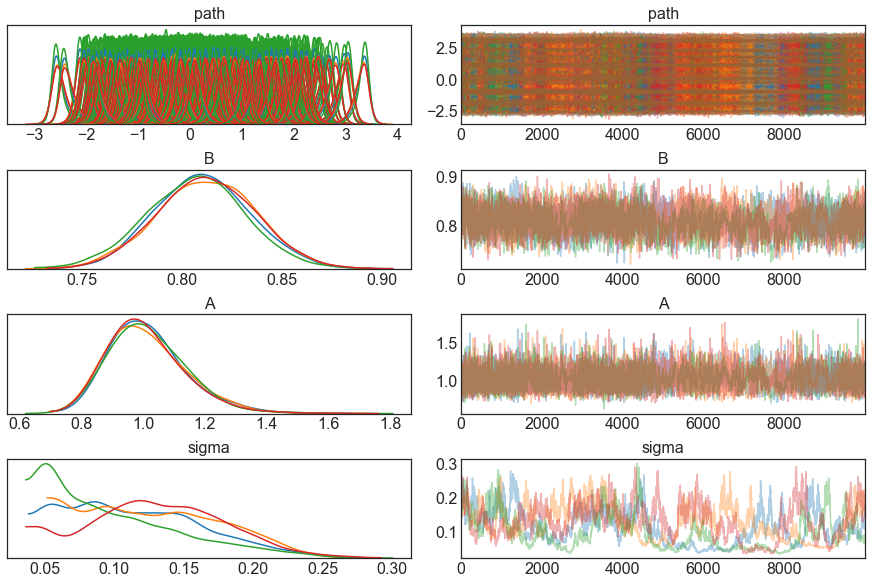

In [32]:
pm.traceplot(trace)

In [33]:
print(-0.802/np.log(0.810))

3.8059798539929925


In [34]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=llp_norm)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:42<00:00, 2794.83draws/s]
The acceptance probability does not match the target. It is 0.8873246180583831, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
B,0.757,0.024,0.712,0.804,0.000,0.000,18168.0,18026.0,18151.0,19822.0,1.0
A,1.025,0.108,0.835,1.231,0.001,0.001,17303.0,16828.0,18206.0,19312.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87377b4e80>,
      dtype=object)

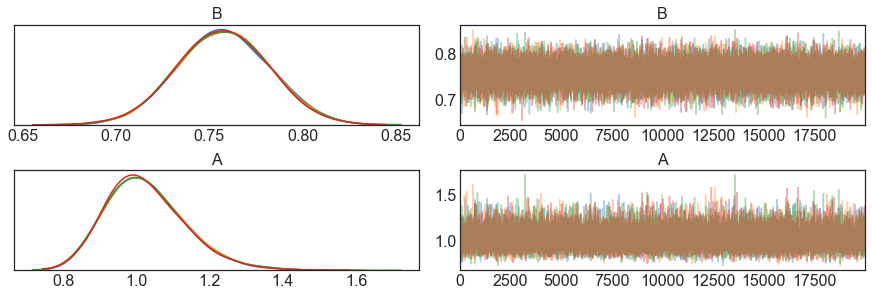

In [36]:
pm.traceplot(trace)

In [37]:
print(-0.802/np.log(0.757))

2.880829644566312


In [38]:
a_bound=20
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)
    sigma = pm.Uniform('sigma',lower=0,upper=5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(llp_norm))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=llp_norm)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 445 divergences: 100%|██████████| 42000/42000 [01:17<00:00, 542.38draws/s] 
There were 445 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3005516838666125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.24869192132870466, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4757539910547083, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [39]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-1.502,0.115,-1.704,-1.270,0.006,0.005,315.0,315.0,495.0,383.0,1.03
path[1],0.171,0.099,-0.034,0.362,0.001,0.001,15998.0,2839.0,16224.0,564.0,1.02
path[2],1.357,0.103,1.144,1.546,0.003,0.002,903.0,903.0,1835.0,454.0,1.03
path[3],1.503,0.104,1.282,1.691,0.003,0.002,1305.0,1305.0,3119.0,417.0,1.03
path[4],0.751,0.099,0.553,0.944,0.001,0.000,22312.0,22312.0,16291.0,566.0,1.03
...,...,...,...,...,...,...,...,...,...,...,...
path[746],0.268,0.098,0.069,0.454,0.001,0.001,27040.0,5887.0,18797.0,658.0,1.03
path[747],0.625,0.102,0.418,0.821,0.001,0.001,7956.0,7956.0,9642.0,535.0,1.03
B,0.764,0.026,0.716,0.812,0.001,0.001,310.0,309.0,312.0,1168.0,1.01
A,1.008,0.104,0.818,1.197,0.003,0.002,1422.0,1422.0,1357.0,2658.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8722cfb4e0>,
      dtype=object)

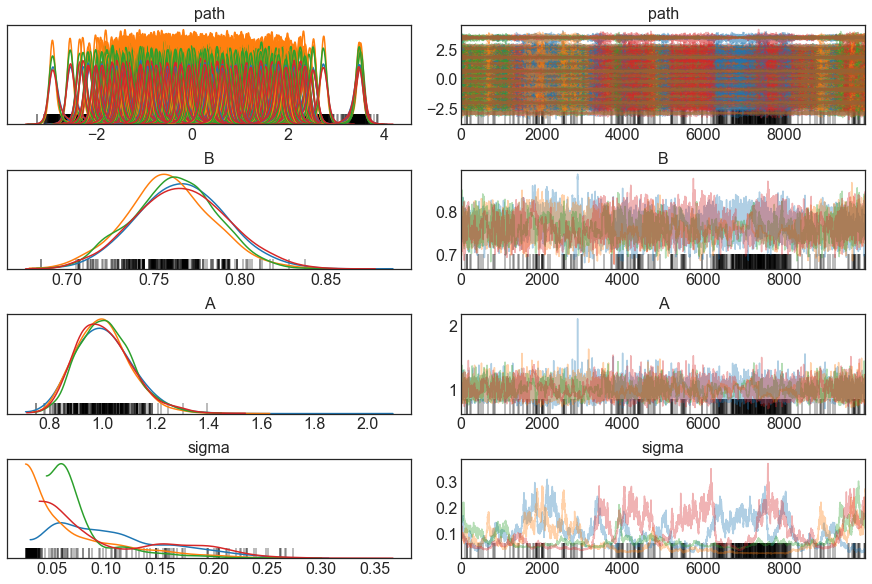

In [40]:
pm.traceplot(trace)

In [41]:
print(-0.802/np.log(0.764))

2.979336077428191


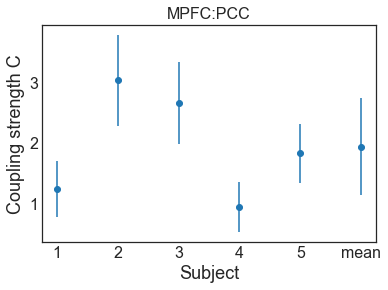

In [56]:
plt.errorbar(x,np.append(results.T[0],[results.T[0].mean()]),
                         yerr=np.append(results.T[1],[results.T[0].std()]),fmt="o")
plt.title("MPFC:PCC")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_pcc.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

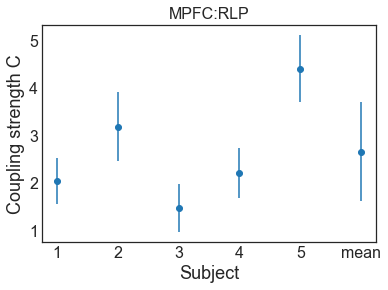

In [57]:
plt.errorbar(x,np.append(results.T[2],[results.T[2].mean()]),
                         yerr=np.append(results.T[3],[results.T[2].std()]),fmt="o")
plt.title("MPFC:RLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_rlp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

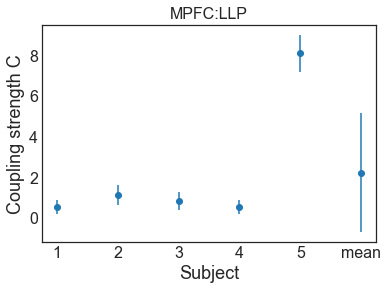

In [58]:
plt.errorbar(x,np.append(results.T[4],[results.T[4].mean()]),
                         yerr=np.append(results.T[5],[results.T[4].std()]),fmt="o")
plt.title("MPFC:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("mpfc_llp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

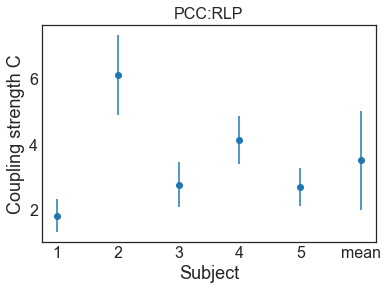

In [59]:
plt.errorbar(x,np.append(results.T[6],[results.T[6].mean()]),
                         yerr=np.append(results.T[7],[results.T[6].std()]),fmt="o")
plt.title("PCC:RLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("pcc_rlp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

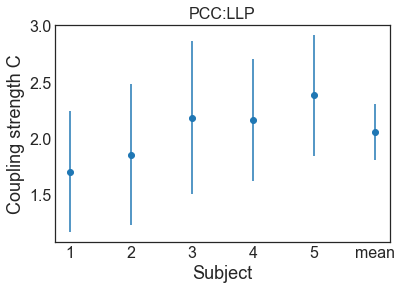

In [60]:
plt.errorbar(x,np.append(results.T[8],[results.T[8].mean()]),
                         yerr=np.append(results.T[9],[results.T[8].std()]),fmt="o")
plt.title("PCC:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("pcc_llp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

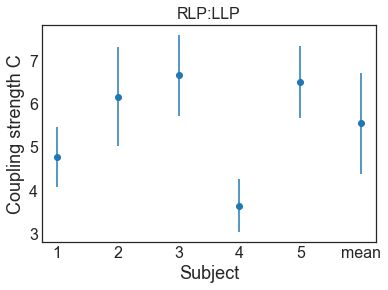

In [61]:
plt.errorbar(x,np.append(results.T[10],[results.T[10].mean()]),
                         yerr=np.append(results.T[11],[results.T[10].std()]),fmt="o")
plt.title("RLP:LLP")
plt.ylabel("Coupling strength C")
plt.xlabel("Subject")
plt.savefig("rlp_llp.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [44]:
np.savetxt(os.path.join(datadir,"results.csv"),results,delimiter = ",")

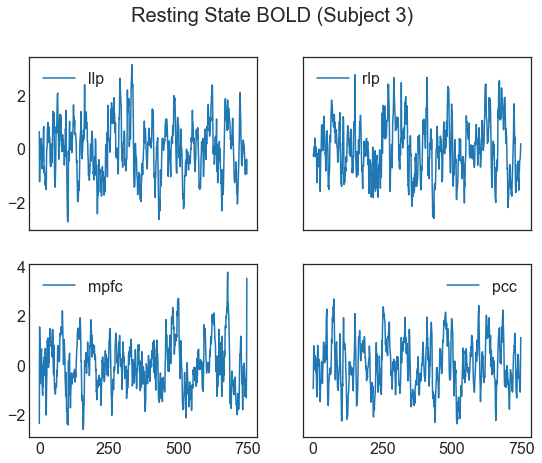

In [53]:
time_series = np.load(os.path.join(datadir,datafilenames[2]))
mpfc = time_series[:,0]
llp = time_series[:,1]
rlp = time_series[:,2]
pcc = time_series[:,3]
    
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(9,7))
f.suptitle('Resting State BOLD (Subject 3)')
ax1.plot(llp, label="llp")
ax1.legend()
ax2.plot(rlp,label = "rlp")
ax2.legend()
ax3.plot(mpfc,label = "mpfc")
ax3.legend()
ax4.plot(pcc,label = "pcc")
ax4.legend()
plt.savefig("subject3.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")